In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as so
from scipy.misc import derivative
from scipy import special as sp
import warnings
from scipy import interpolate

# $E_Q$ vs $E_P$ joint distribution

In the previous docmentation, the distribution that was being handled was the yield dietribution, but as was discussed, that distribution leads to some pathological nature which makes analysis hard. In order to avoid this, we can work directly with the raw measured variables phonon energy ($E_P$) and charge energy ($E_Q$) (which are not pathological). 

To properly analyze a given event with a certain measured phonon and charge energy, we need to properly understand their distributions. The following block of code lays down the foundation of some of the mathematics used later on, but this block isn't referenced to in others. It is supposed to be a model of the joint distribution given a recoil energy ($E_r$), but it is too rudimentary to deal with all of the complexities involved.

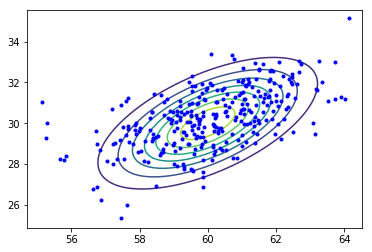

In [2]:
#First Attempt (For a fixed true Er)
#Parameters
stdQ = 1
stdP = 1
V = 1
eps = 1
Er = 30
F = 1/20
meanN = Er/eps
stdN = math.sqrt(F*meanN)

#Analytical Solution
ac = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2

def bc(p0, q0):
    ans = (V*(Er-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    return ans

def cc(p0, q0):
    ans = ((((Er-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    return ans

def fc(p0, q0):
    ans = np.exp(-cc(p0,q0)+(bc(p0,q0)**2)/(4*ac))/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*ac))
    return ans

#Sampling
k = 300

EPdata = []
EQdata = []

for k0 in range(k):
    N0 = np.random.normal(meanN,stdN,1)
    xP = np.random.normal(0,stdP,1)
    xQ = np.random.normal(0,stdQ,1)
    EP = Er + V*N0 + xP
    EQ = eps*N0 + xQ
    EPdata.append(EP)
    EQdata.append(EQ)
    
    
minP = np.min(EPdata)
minQ = np.min(EQdata)
maxP = np.max(EPdata)
maxQ = np.max(EQdata)
stepP = (maxP-minP)/100
stepQ = (maxQ-minQ)/100
p = np.arange(minP-5*stepP, maxP+5*stepP, stepP)
q = np.arange(minQ-5*stepQ, maxQ+5*stepQ, stepQ)
pp, qq = np.meshgrid(p, q, sparse=True)

z = fc(pp,qq)

#print(z)
#print(fc(p[0],q[0]),fc(p[1],q[0]),z[0][0],z[0][1])

#print(np.shape(z),np.shape(p),np.shape(q),np.shape(pp),np.shape(qq))
#print(pp[0,1])
print()

plt.plot(EPdata,EQdata,'b.')
plt.contour(p,q,z)
plt.show()

This next block of code properly integrates the previous block's idea over an $E_r$ distribution with a constant fano factor. It does not account for the variation in the nuclear fano factor.

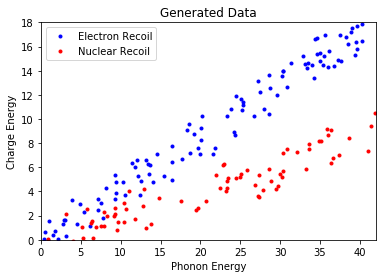

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in sqrt
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:571: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[0]:
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:582: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-2]:
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:587: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-1]:
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:575: RuntimeWarning: invalid value encountered in less
  if fxe < fxr:


0.001271647043007024
0.0012848560437242705


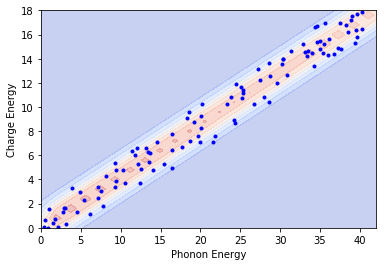

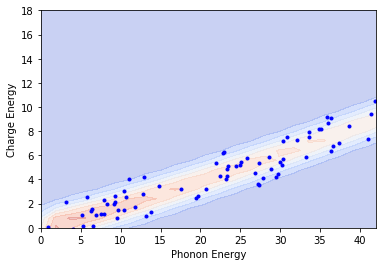

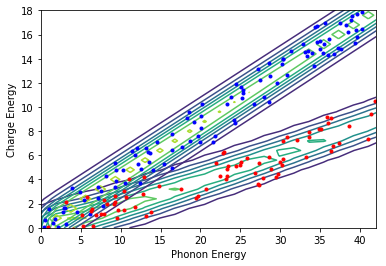

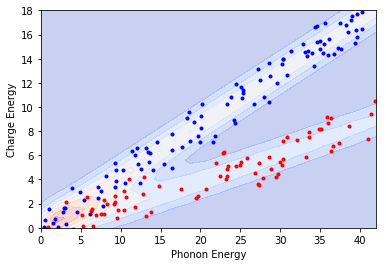

In [3]:
#Parameters
alphaP = 1
betaP  = 0
gammaP = 0
alphaQ = 1
betaQ  = 0
gammaQ = 0
eps    = .003
V      = .004
F0      = .3
lam    = 100 #in keV
lamN   = 18   #in keV
a      = .16
b      = .18
weight0 = .3

#Sample Size
J = 1000

#Data Generation
EPdataE = []
EQdataE = []
EPdataN = []
EQdataN = []
ErdataE = []
ErdataN = []

for j in range(int(np.floor(J*(1-weight0)))):
    Er = np.random.exponential(lam,1)
    sigP = math.sqrt(alphaP+betaP*Er*(1+V/eps)+gammaP*((Er*(1+V/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*Er+gammaQ*(Er**2))
    N = np.random.normal(Er/eps,math.sqrt(F0*Er/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataE.append(Er)
    EPdataE.append(EP)
    EQdataE.append(EQ)

for j in range(int(np.floor(J*weight0))):
    Er = np.random.exponential(lam,1)
    ErY = a*(Er**(b+1))
    sigP = math.sqrt(alphaP+betaP*(Er+V*ErY/eps)+gammaP*((Er+V*ErY/eps)**2))
    sigQ = math.sqrt(alphaQ+betaQ*ErY+gammaQ*(ErY**2))
    N = np.random.normal(ErY/eps,math.sqrt(F0*ErY/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataN.append(Er)
    EPdataN.append(EP)
    EQdataN.append(EQ)
"""
density = True
bins = 100
exphist, bin_edges = np.histogram(ErdataN, bins, density=density)  

plt.plot(bin_edges[0:-1],exphist, drawstyle = "steps-mid", color="red")
plt.show()
"""

#Pseudo-Analytic Solution #1    
def fv(p0, q0, x0, F):
    stdP = np.sqrt(alphaP+betaP*x0+gammaP*(x0**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0+gammaQ*(x0**2))
    stdN = np.sqrt(F*x0/eps)
    meanN = x0/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    f_pq_r = np.exp((bv**2)/(4*av)-cv)/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*av))
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

def fvN(p0, q0, x0, F):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F*x0Y/eps)
    meanN = x0Y/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    f_pq_r = np.exp((bv**2)/(4*av)-cv)/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*av))
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

def fvN_exp(p0, q0, x0, F):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F*x0Y/eps)
    meanN = x0Y/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    ans = -((bv**2)/(4*av)-cv)
    return ans

def fvN_expD2(p0, q0, x0, F):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F*x0Y/eps)
    meanN = x0Y/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    avp = -(eps/(2*F*a))*(b+1)/((x0**2)*np.absolute(x0)**(b))
    av2p = (eps/(2*F*a))*(b+1)*(b+2)/((x0**3)*np.absolute(x0)**(b))
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    bvp = V/(stdP**2)
    cv2p = 1/(stdP)**2+(a*(b+1)*b*(np.absolute(x0)**(b)))/(2*F*eps*x0)
    ans = cv2p-(2*(av**2)*(bvp**2)+(bv**2)*(2*(avp**2)-av*av2p)-4*av*bv*avp*bvp)/(4*(av**3))
    return ans

f = lambda x0, p0, q0, F: fv(p0,q0,x0,F)
fN = lambda x0, p0, q0, F: fvN(p0,q0,x0,F)
fN_exp = lambda x0, p0, q0, F: fvN_exp(p0,q0,x0,F)
f_vec = np.vectorize(f)
fN_vec_exp = np.vectorize(fN_exp)

def Fv0(p0,q0,F):
    ans = integrate.quad(f, 0, np.inf, args = (p0,q0,F,))[0]
    return ans

def FvE(p0,q0,F):
    sigP = math.sqrt(alphaP+betaP*(p0-(V*q0/eps))+gammaP*((p0-(V*q0/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*(p0-(V*q0/eps))+gammaQ*((p0-(V*q0/eps))**2))
    L = ((V/(sigP**2))**2)/(2*(((V/sigP)**2)+((eps/sigQ)**2)))
    delt = -((sigP**2)/V)*((eps*q0)/(sigQ**2)+(1/F)+(V*p0)/(sigP**2))
    H = eps/(F*(((V/sigP)**2)+((eps/sigQ)**2)))
    a0 = -1/(2*sigP)+L
    b0 = p0/(sigP**2)-1/(2*F*eps)-1/lam+L*(2*delt-H)
    d0 = -L*H*((delt-H)**2)
    cubCoeff = [2*a0,(b0+4*a0*H),2*H*(b0+a0*H),b0*H*H-d0]
    solns = np.roots(cubCoeff)
    Rsolns = []
    for sol in solns:
        if np.isreal(sol):
            Rsolns.append(sol)
    loc = np.max(Rsolns)
    W0 = (a0+d0/((loc+H)**3))
    sca = np.sqrt(-1/(2*W0))
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(f, minx, maxx, args = (p0,q0,F,))[0]
    #ranlist = np.arange(minx,maxx,(maxx-minx)/50)
    #print(ranlist)
    #plt.plot(ranlist,f_vec(ranlist,p0,q0))
    #plt.title("(Ep = " + str(p0) + ", Eq = " + str(q0) + ")")
    #plt.show()
    return ans

def FvN(p0,q0,F):
    Er0 = p0-(V*q0/eps)
    Er0Y = a*(np.absolute(Er0)**(b))*Er0
    #sigP = math.sqrt(alphaP+betaP*(Er0+Er0Y*V/eps)+gammaP*((Er0+Er0Y*V/eps)**2))
    #sigQ = math.sqrt(alphaQ+betaQ*(Er0Y)+gammaQ*((Er0Y)**2))
    #loc = so.minimize(fN_exp,x0 = [np.absolute(Er0Y)], args=(p0,q0)) 
    loc = so.fmin(fN_exp,x0 = np.absolute(Er0Y)+1, args=(p0,q0,F), disp = False)
    W0 = fvN_expD2(p0,q0,loc,F)
    sca = np.sqrt(1/(2*W0))
    
    #ran = np.arange(-20,20,.1)
    #plt.plot(ran,fN_vec_exp(ran,p0,q0))
    #plt.legend()
    #plt.vlines(loc,0,100)
    #plt.vlines(loc+sca,0,50)
    #plt.vlines(loc-sca,0,50)
    #plt.vlines(Er0,0,200)
    #plt.show()
    
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(fN, minx, maxx, args = (p0,q0,F,))[0]
    #ranlist = np.arange(minx,maxx,(maxx-minx)/50)
    #print(ranlist)
    #plt.plot(ranlist,f_vec(ranlist,p0,q0))
    #plt.title("(Ep = " + str(p0) + ", Eq = " + str(q0) + ")")
    #plt.show()
    #print(ans)
    return ans

def FvNE(p0,q0,FE,FN,weight):
    ans = FvN(p0,q0,FN)*weight+(1-weight)*FvE(p0,q0,FE)
    return ans

Fv0_vec = np.vectorize(Fv0)
FvE_vec = np.vectorize(FvE)

#Graphing (Electron vs Nuclear Generated Data)
xE = EPdataE
yE = EQdataE
xN = EPdataN
yN = EQdataN

plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
#plt.ylim(0,100)
#plt.xlim(0,100*(1+V/eps))
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.title("Generated Data")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.legend()
plt.show()

#Graphing (Electron Recoil, Pseudo-Analytic vs Data Generation)
minP = 0  #min(xE)
minQ = 0  #min(yE)
maxP = 20*(1+V/eps)  #max(xE)
maxQ = 20  #max(yE)
stepNo = 25
stepP = (maxP-minP)/stepNo
stepQ = (maxQ-minQ)/stepNo
p1 = np.arange(minP, maxP, stepP)
q1 = np.arange(minQ, maxQ, stepQ)
pp1, qq1 = np.meshgrid(p1, q1, sparse=True)

zzE = [[0 for x in range(len(q1))] for y in range(len(p1))]
zzN = [[0 for x in range(len(q1))] for y in range(len(p1))]
zzNE = [[0 for x in range(len(q1))] for y in range(len(p1))]

count1 = 0
for ppp1 in p1:
    count2 = 0
    for qqq1 in q1:
        zzE[count2][count1] = FvE(ppp1,qqq1,F0)
        zzN[count2][count1] = FvN(ppp1,qqq1,F0)
        zzNE[count2][count1] = FvNE(ppp1,qqq1,F0,F0,weight0)
        count2+=1
    count1+=1

#print(zz)
ErTest = 20
EpTest = ErTest*(1 + (V/eps))
EqTest = ErTest

print(fv(EpTest,EqTest,ErTest,F0))
print(FvE(EpTest,EqTest,F0))

#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zzE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()

#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zzN, cmap='coolwarm',alpha=.3)
plt.plot(xN,yN,'b.', label = "Nuclear Recoil")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()

plt.contour(p1,q1,zzN)
plt.contour(p1,q1,zzE)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()

plt.contourf(p1,q1,zzNE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()


This next block of code was a test to see how different constant fano factors impact the plots.

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in sqrt


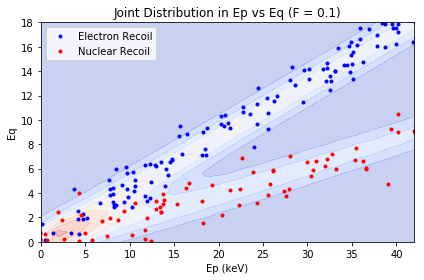

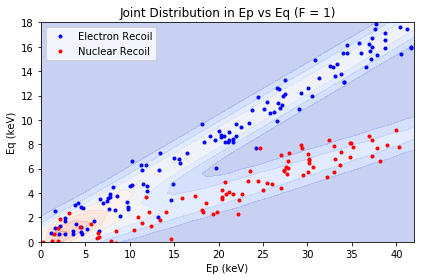

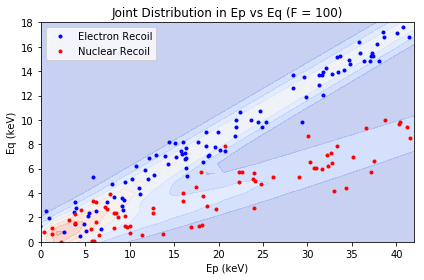

In [4]:
#Parameters
alphaP = 1
betaP  = 0
gammaP = 0
alphaQ = 1
betaQ  = 0
gammaQ = 0
eps    = .003
V      = .004
F0     = .3
F1     = .1
F2     = 1
F3     = 100
lam    = 100 #in keV
lamN   = 18   #in keV
a      = .16
b      = .18
weight0 = .3

#Sample Size
J = 1000


#Data Generation
EPdataE1 = []
EQdataE1 = []
EPdataN1 = []
EQdataN1 = []
ErdataE1 = []
ErdataN1 = []
EPdataE2 = []
EQdataE2 = []
EPdataN2 = []
EQdataN2 = []
ErdataE2 = []
ErdataN2 = []
EPdataE3 = []
EQdataE3 = []
EPdataN3 = []
EQdataN3 = []
ErdataE3 = []
ErdataN3 = []

for j in range(int(np.floor(J*(1-weight0)))):
    Er = np.random.exponential(lam,1)
    sigP = math.sqrt(alphaP+betaP*Er*(1+V/eps)+gammaP*((Er*(1+V/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*Er+gammaQ*(Er**2))
    N = np.random.normal(Er/eps,math.sqrt(F0*Er/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataE1.append(Er)
    EPdataE1.append(EP)
    EQdataE1.append(EQ)
    Er = np.random.exponential(lam,1)
    sigP = math.sqrt(alphaP+betaP*Er*(1+V/eps)+gammaP*((Er*(1+V/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*Er+gammaQ*(Er**2))
    N = np.random.normal(Er/eps,math.sqrt(F0*Er/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataE2.append(Er)
    EPdataE2.append(EP)
    EQdataE2.append(EQ)
    Er = np.random.exponential(lam,1)
    sigP = math.sqrt(alphaP+betaP*Er*(1+V/eps)+gammaP*((Er*(1+V/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*Er+gammaQ*(Er**2))
    N = np.random.normal(Er/eps,math.sqrt(F0*Er/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataE3.append(Er)
    EPdataE3.append(EP)
    EQdataE3.append(EQ)

for j in range(int(np.floor(J*weight0))):
    Er = np.random.exponential(lam,1)
    ErY = a*(Er**(b+1))
    sigP = math.sqrt(alphaP+betaP*(Er+V*ErY/eps)+gammaP*((Er+V*ErY/eps)**2))
    sigQ = math.sqrt(alphaQ+betaQ*ErY+gammaQ*(ErY**2))
    N = np.random.normal(ErY/eps,math.sqrt(F1*ErY/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataN1.append(Er)
    EPdataN1.append(EP)
    EQdataN1.append(EQ)
    Er = np.random.exponential(lam,1)
    ErY = a*(Er**(b+1))
    sigP = math.sqrt(alphaP+betaP*(Er+V*ErY/eps)+gammaP*((Er+V*ErY/eps)**2))
    sigQ = math.sqrt(alphaQ+betaQ*ErY+gammaQ*(ErY**2))
    N = np.random.normal(ErY/eps,math.sqrt(F2*ErY/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataN2.append(Er)
    EPdataN2.append(EP)
    EQdataN2.append(EQ)
    Er = np.random.exponential(lam,1)
    ErY = a*(Er**(b+1))
    sigP = math.sqrt(alphaP+betaP*(Er+V*ErY/eps)+gammaP*((Er+V*ErY/eps)**2))
    sigQ = math.sqrt(alphaQ+betaQ*ErY+gammaQ*(ErY**2))
    N = np.random.normal(ErY/eps,math.sqrt(F3*ErY/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataN3.append(Er)
    EPdataN3.append(EP)
    EQdataN3.append(EQ)

    
minP = 0  
minQ = 0  
maxP = 20*(1+V/eps)
maxQ = 20
stepNo = 25
stepP = (maxP-minP)/stepNo
stepQ = (maxQ-minQ)/stepNo
p1 = np.arange(minP, maxP, stepP)
q1 = np.arange(minQ, maxQ, stepQ)
pp1, qq1 = np.meshgrid(p1, q1, sparse=True)

zzNE1 = [[0 for x in range(len(q1))] for y in range(len(p1))]
zzNE2 = [[0 for x in range(len(q1))] for y in range(len(p1))]
zzNE3 = [[0 for x in range(len(q1))] for y in range(len(p1))]

zzN1 = [[0 for x in range(len(q1))] for y in range(len(p1))]
zzN2 = [[0 for x in range(len(q1))] for y in range(len(p1))]
zzN3 = [[0 for x in range(len(q1))] for y in range(len(p1))]

count1 = 0
for ppp1 in p1:
    count2 = 0
    for qqq1 in q1:
        zzNE1[count2][count1] = FvNE(ppp1,qqq1,F0,F1,weight0)
        zzNE2[count2][count1] = FvNE(ppp1,qqq1,F0,F2,weight0)
        zzNE3[count2][count1] = FvNE(ppp1,qqq1,F0,F3,weight0)
        zzN1[count2][count1] = FvN(ppp1,qqq1,F1)
        zzN2[count2][count1] = FvN(ppp1,qqq1,F2)
        zzN3[count2][count1] = FvN(ppp1,qqq1,F3)
        count2+=1
    count1+=1

    
plt.contourf(p1,q1,zzNE1, cmap='coolwarm',alpha=.3)
#plt.contour(p1,q1,zzN1)
plt.plot(EPdataE1,EQdataE1,'b.', label = "Electron Recoil")
plt.plot(EPdataN1,EQdataN1,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.title("Joint Distribution in Ep vs Eq (F = " + str(F1) + ")")
plt.xlabel("Ep (keV)")
plt.ylabel("Eq")
plt.legend()
plt.tight_layout()
plt.savefig('figures/figureF1.png')
plt.show()

plt.contourf(p1,q1,zzNE2, cmap='coolwarm',alpha=.3)
#plt.contour(p1,q1,zzN2)
plt.plot(EPdataE2,EQdataE2,'b.', label = "Electron Recoil")
plt.plot(EPdataN2,EQdataN2,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.title("Joint Distribution in Ep vs Eq (F = " + str(F2) + ")")
plt.xlabel("Ep (keV)")
plt.ylabel("Eq (keV)")
plt.legend()
plt.tight_layout()
plt.savefig('figures/figureF2.png')
plt.show()

plt.contourf(p1,q1,zzNE3, cmap='coolwarm',alpha=.3)
#plt.contour(p1,q1,zzN3)
plt.plot(EPdataE3,EQdataE3,'b.', label = "Electron Recoil")
plt.plot(EPdataN3,EQdataN3,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.title("Joint Distribution in Ep vs Eq (F = " + str(F3) + ")")
plt.xlabel("Ep (keV)")
plt.ylabel("Eq (keV)")
plt.legend()
plt.tight_layout()
plt.savefig('figures/figureF3.png')
plt.show()

This next block of code is essentially the most important block, as it correctly models the joint distribution with a varying nuclear Fano factor.

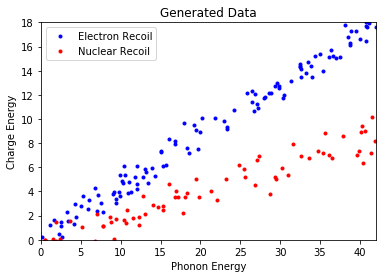

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in sqrt
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


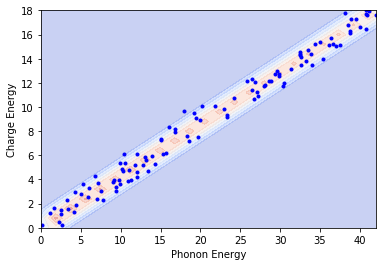

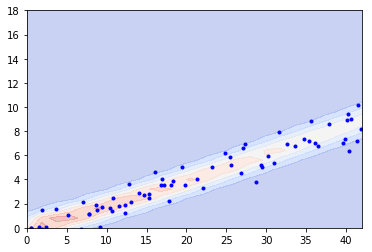

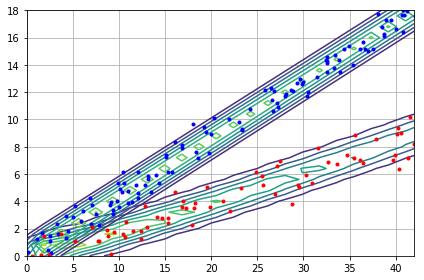

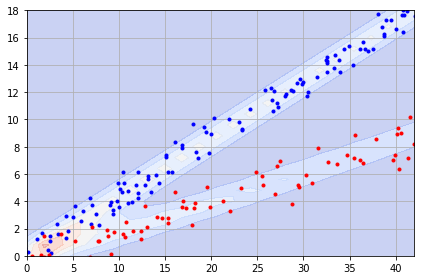

In [5]:
#Parameters
alphaP = .5
betaP  = 0
gammaP = 0
alphaQ = .5
betaQ  = 0
gammaQ = 0
eps    = .003
V      = .004
F0      = .3
lam    = 100 #in keV
lamN   = 18   #in keV
a      = .16
b      = .18
weight0 = .3

#Sample Size
J = 1000

def FanoE(Er):
    return F0

def FanoN(Er):
    return .87*Er

#Data Generation
EPdataE = []
EQdataE = []
EPdataN = []
EQdataN = []
ErdataE = []
ErdataN = []

for j in range(int(np.floor(J*(1-weight0)))):
    Er = np.random.exponential(lam,1)
    sigP = math.sqrt(alphaP+betaP*Er*(1+V/eps)+gammaP*((Er*(1+V/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*Er+gammaQ*(Er**2))
    N = np.random.normal(Er/eps,math.sqrt(FanoE(Er)*Er/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataE.append(Er)
    EPdataE.append(EP)
    EQdataE.append(EQ)

for j in range(int(np.floor(J*weight0))):
    Er = np.random.exponential(lam,1)
    ErY = a*(Er**(b+1))
    sigP = math.sqrt(alphaP+betaP*(Er+V*ErY/eps)+gammaP*((Er+V*ErY/eps)**2))
    sigQ = math.sqrt(alphaQ+betaQ*ErY+gammaQ*(ErY**2))
    N = np.random.normal(ErY/eps,math.sqrt(FanoN(Er)*ErY/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataN.append(Er)
    EPdataN.append(EP)
    EQdataN.append(EQ)
"""
density = True
bins = 100
exphist, bin_edges = np.histogram(ErdataN, bins, density=density)  

plt.plot(bin_edges[0:-1],exphist, drawstyle = "steps-mid", color="red")
plt.show()
"""

#Pseudo-Analytic Solution #1    
def fvarFv(p0, q0, x0, F=lambda Er:F0):
    stdP = np.sqrt(alphaP+betaP*x0+gammaP*(x0**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0+gammaQ*(x0**2))
    stdN = np.sqrt(F(x0)*x0/eps)
    meanN = x0/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    f_pq_r = np.exp((bv**2)/(4*av)-cv)/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*av))
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

def fvarFvN(p0, q0, x0, F=lambda Er:F0):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F(x0)*x0Y/eps)
    meanN = x0Y/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    f_pq_r = np.exp((bv**2)/(4*av)-cv)/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*av))
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

def fvarFv_exp(p0, q0, x0, F=lambda Er:F0):
    stdP = np.sqrt(alphaP+betaP*(x0)+gammaP*((x0)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0+gammaQ*(x0**2))
    stdN = np.sqrt(F(x0)*x0/eps)
    meanN = x0/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    ans = -((bv**2)/(4*av)-cv)
    return ans

def fvarFvN_exp(p0, q0, x0, F=lambda Er:F0):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F(x0)*x0Y/eps)
    meanN = x0Y/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    ans = -((bv**2)/(4*av)-cv)
    return ans

fvarF = lambda x0, p0, q0: fvarFv(p0,q0,x0,FanoE)
fvarFN = lambda x0, p0, q0: fvarFvN(p0,q0,x0,FanoN)
fvarF_exp = lambda x0, p0, q0: fvarFv_exp(p0,q0,x0,FanoE)
fvarFN_exp = lambda x0, p0, q0: fvarFvN_exp(p0,q0,x0,FanoN)

def FvarFE(p0,q0):
    Er0 = p0-(V*q0/eps)
    loc = so.fmin(fvarF_exp,x0 = np.absolute(Er0)+1, args=(p0,q0), disp = False)
    #W0 = #second derivative of fvN_exp at Er=loc
    sca = 10 #np.sqrt(-1/(2*W0))
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(fvarF, minx, maxx, args = (p0,q0,))[0]
    return ans

def FvarFN(p0,q0):
    Er0 = p0-(V*q0/eps)
    Er0Y = a*(np.absolute(Er0)**(b))*Er0
    loc = so.fmin(fvarFN_exp,x0 = np.absolute(Er0Y)+1, args=(p0,q0), disp = False)
    #W0 = fvN_expD2(p0,q0,loc,F) #second derivative of fvN_exp at Er=loc
    sca = 10 #np.sqrt(1/(2*W0))
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(fvarFN, minx, maxx, args = (p0,q0,))[0]
    #ranlist = np.arange(minx,maxx,(maxx-minx)/50)
    #print(ranlist)
    #plt.plot(ranlist,f_vec(ranlist,p0,q0))
    #plt.title("(Ep = " + str(p0) + ", Eq = " + str(q0) + ")")
    #plt.show()
    #print(ans)
    return ans

def FvarFNE(p0,q0,weight=weight0):
    ans = FvarFN(p0,q0)*weight+(1-weight)*FvarFE(p0,q0)
    return ans

#Graphing (Electron vs Nuclear Generated Data)
xE = EPdataE
yE = EQdataE
xN = EPdataN
yN = EQdataN

plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
#plt.ylim(0,100)
#plt.xlim(0,100*(1+V/eps))
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.title("Generated Data")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.legend()
plt.show()

#Graphing (Electron Recoil, Pseudo-Analytic vs Data Generation)
minP = 0  #min(xE)
minQ = 0  #min(yE)
maxP = 20*(1+V/eps)  #max(xE)
maxQ = 20  #max(yE)
stepNo = 25
stepP = (maxP-minP)/stepNo
stepQ = (maxQ-minQ)/stepNo
p1 = np.arange(minP, maxP, stepP)
q1 = np.arange(minQ, maxQ, stepQ)
pp1, qq1 = np.meshgrid(p1, q1, sparse=True)

FvarFEv = np.vectorize(FvarFE)
FvarFNv = np.vectorize(FvarFN)
FvarFNEv = np.vectorize(FvarFNE)

zzE = FvarFEv(pp1,qq1)
zzN = FvarFNv(pp1,qq1)
zzNE = FvarFNEv(pp1,qq1)


#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zzE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()

#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zzN, cmap='coolwarm',alpha=.3)
plt.plot(xN,yN,'b.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()

plt.contour(p1,q1,zzN)
plt.contour(p1,q1,zzE)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.savefig('figures/figureVF1.png')
plt.grid()
plt.show()

plt.contourf(p1,q1,zzNE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.savefig('figures/figureVF2.png')
plt.grid()
plt.show()


The next section is modeling this with the only incorrect assumption being that $E_P$ and $E_Q$ are independent.

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


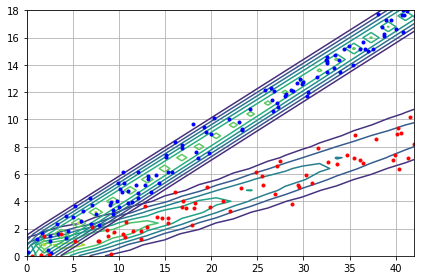

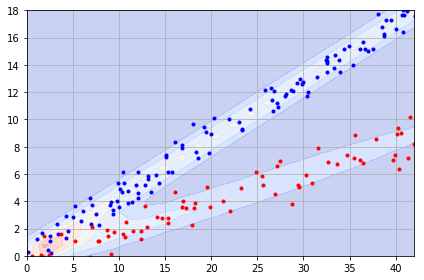

In [6]:
#Erroneous Plot
def bfvarFv(p0, q0, x0, F=lambda Er:F0):
    stdP = np.sqrt(alphaP+betaP*x0+gammaP*(x0**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0+gammaQ*(x0**2))
    stdN = np.sqrt(F(x0)*x0/eps)
    meanN = x0/eps
    meanP = x0+V*meanN
    meanQ = eps*meanN
    sigP = np.sqrt(stdP**2+F(x0)*meanN*(eps**2))
    sigQ = np.sqrt(stdQ**2+F(x0)*meanN*(V**2))
    f_pq_r=np.exp(-(((p0-meanP)**2)/(2*(sigP**2))+((q0-meanQ)**2)/(2*(sigQ**2))))/(2*math.pi*sigP*sigQ)
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

def bfvarFvN(p0, q0, x0, F=lambda Er:F0):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F(x0)*x0Y/eps)
    meanN = x0Y/eps
    meanP = x0+V*meanN
    meanQ = eps*meanN
    sigP = np.sqrt(stdP**2+F(x0)*meanN*(eps**2))
    sigQ = np.sqrt(stdQ**2+F(x0)*meanN*(V**2))
    f_pq_r=np.exp(-(((p0-meanP)**2)/(2*(sigP**2))+((q0-meanQ)**2)/(2*(sigQ**2))))/(2*math.pi*sigP*sigQ)
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

def bfvarFv_exp(p0, q0, x0, F=lambda Er:F0):
    stdP = np.sqrt(alphaP+betaP*x0+gammaP*(x0**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0+gammaQ*(x0**2))
    stdN = np.sqrt(F(x0)*x0/eps)
    meanN = x0/eps
    meanP = x0+V*meanN
    meanQ = eps*meanN
    sigP = np.sqrt(stdP**2+F(x0)*meanN*(eps**2))
    sigQ = np.sqrt(stdQ**2+F(x0)*meanN*(V**2))
    ans = ((((p0-meanP)**2)/(2*(sigP**2))+((q0-meanQ)**2)/(2*(sigQ**2))))
    return ans

def bfvarFvN_exp(p0, q0, x0, F=lambda Er:F0):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F(x0)*x0Y/eps)
    meanN = x0Y/eps
    meanP = x0+V*meanN
    meanQ = eps*meanN
    sigP = np.sqrt(stdP**2+F(x0)*meanN*(eps**2))
    sigQ = np.sqrt(stdQ**2+F(x0)*meanN*(V**2))
    ans = ((((p0-meanP)**2)/(2*(sigP**2))+((q0-meanQ)**2)/(2*(sigQ**2))))
    return ans

bfvarF = lambda x0, p0, q0: bfvarFv(p0,q0,x0,FanoE)
bfvarFN = lambda x0, p0, q0: bfvarFvN(p0,q0,x0,FanoN)
bfvarF_exp = lambda x0, p0, q0: bfvarFv_exp(p0,q0,x0,FanoE)
bfvarFN_exp = lambda x0, p0, q0: bfvarFvN_exp(p0,q0,x0,FanoN)

def bFvarFE(p0,q0):
    Er0 = p0-(V*q0/eps)
    loc = so.fmin(bfvarF_exp,x0 = np.absolute(Er0)+1, args=(p0,q0), disp = False)
    #W0 = #second derivative of fvN_exp at Er=loc
    sca = 10 #np.sqrt(-1/(2*W0))
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(bfvarF, minx, maxx, args = (p0,q0,))[0]
    return ans

def bFvarFN(p0,q0):
    Er0 = p0-(V*q0/eps)
    Er0Y = a*(np.absolute(Er0)**(b))*Er0
    loc = so.fmin(bfvarFN_exp,x0 = np.absolute(Er0Y)+1, args=(p0,q0), disp = False)
    #W0 = fvN_expD2(p0,q0,loc,F) #second derivative of fvN_exp at Er=loc
    sca = 10 #np.sqrt(1/(2*W0))
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(bfvarFN, minx, maxx, args = (p0,q0,))[0]
    #ranlist = np.arange(minx,maxx,(maxx-minx)/50)
    #print(ranlist)
    #plt.plot(ranlist,f_vec(ranlist,p0,q0))
    #plt.title("(Ep = " + str(p0) + ", Eq = " + str(q0) + ")")
    #plt.show()
    #print(ans)
    return ans

def bFvarFNE(p0,q0,weight=weight0):
    ans = bFvarFN(p0,q0)*weight+(1-weight)*bFvarFE(p0,q0)
    return ans

bFvarFEv = np.vectorize(bFvarFE)
bFvarFNv = np.vectorize(bFvarFN)
bFvarFNEv = np.vectorize(bFvarFNE)

bzzE = bFvarFEv(pp1,qq1)
bzzN = bFvarFNv(pp1,qq1)
bzzNE = bFvarFNEv(pp1,qq1)

plt.contour(p1,q1,bzzN)
plt.contour(p1,q1,bzzE)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
"""
for pltindex in range(9):
    plt.plot(p,(p*r-20*pltindex)/k, linestyle = "--")
"""
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.savefig('figures/bfigureVF1.png')
plt.grid()
plt.show()

plt.contourf(p1,q1,bzzNE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.savefig('figures/bfigureVF2.png')
plt.grid()
plt.show()

The following two sections of code are the same as the previous two where the contour plots are probability contour plots instead of the contour plot of the probability density.

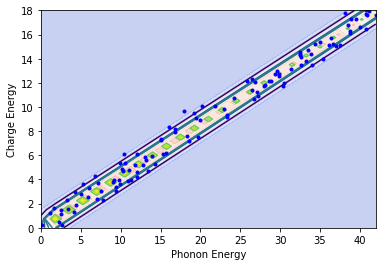

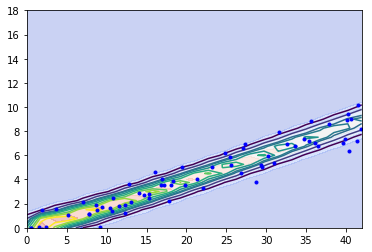

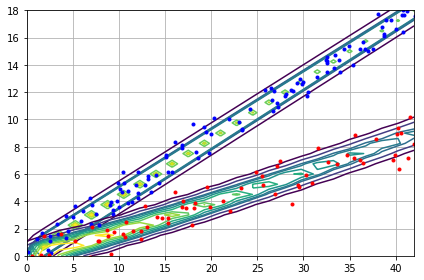

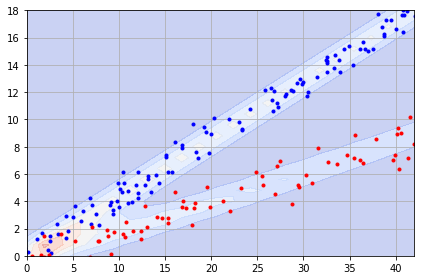

In [7]:
zzEsum = zzE / zzE.sum()
zzNsum = zzN / zzN.sum()
zzNEsum = zzNE / zzNE.sum()

n = 1000
tE = np.linspace(0, zzEsum.max(), n)
tN = np.linspace(0, zzNsum.max(), n)
tNE = np.linspace(0, zzNEsum.max(), n)
integralE = ((zzEsum >= tE[:, None, None]) * zzEsum).sum(axis=(1,2))
integralN = ((zzNsum >= tN[:, None, None]) * zzNsum).sum(axis=(1,2))
integralNE = ((zzNEsum >= tNE[:, None, None]) * zzNEsum).sum(axis=(1,2))

from scipy import interpolate
contour_levels=np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
interpE = interpolate.interp1d(integralE, tE)
interpN = interpolate.interp1d(integralN, tN)
interpNE = interpolate.interp1d(integralNE, tNE)
tE_contours = interpE(contour_levels)
tN_contours = interpN(contour_levels)
tNE_contours = interpNE(contour_levels)

#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zzE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.contour(zzEsum, tE_contours, extent=[0,18*(1+V/eps),0,18])
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()

#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zzN, cmap='coolwarm',alpha=.3)
plt.plot(xN,yN,'b.', label = "Nuclear Recoil")
plt.contour(zzNsum, tN_contours, extent=[0,18*(1+V/eps),0,18])
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()


plt.contour(zzEsum, tE_contours, extent=[0,18*(1+V/eps),0,18])
plt.contour(zzNsum, tN_contours, extent=[0,18*(1+V/eps),0,18])
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.grid()
plt.show()

plt.contourf(p1,q1,zzNE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.grid()
plt.show()

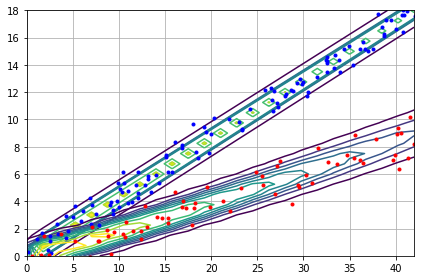

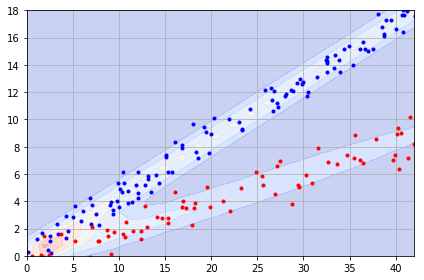

In [8]:
bzzEsum = bzzE / bzzE.sum()
bzzNsum = bzzN / bzzN.sum()
bzzNEsum = bzzNE / bzzNE.sum()

btE = np.linspace(0, bzzEsum.max(), n)
btN = np.linspace(0, bzzNsum.max(), n)
btNE = np.linspace(0, bzzNEsum.max(), n)
bintegralE = ((bzzEsum >= btE[:, None, None]) * bzzEsum).sum(axis=(1,2))
bintegralN = ((bzzNsum >= btN[:, None, None]) * bzzNsum).sum(axis=(1,2))
bintegralNE = ((bzzNEsum >= btNE[:, None, None]) * bzzNEsum).sum(axis=(1,2))

binterpE = interpolate.interp1d(bintegralE, btE)
binterpN = interpolate.interp1d(bintegralN, btN)
binterpNE = interpolate.interp1d(bintegralNE, btNE)
btE_contours = binterpE(contour_levels)
btN_contours = binterpN(contour_levels)
btNE_contours = binterpNE(contour_levels)


plt.contour(bzzEsum, btE_contours, extent=[0,18*(1+V/eps),0,18])
plt.contour(bzzNsum, btN_contours, extent=[0,18*(1+V/eps),0,18])
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.grid()
plt.show()

plt.contourf(p1,q1,bzzNE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.grid()
plt.show()

# Decision Making Algorithm

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in sqrt
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


('Nuclear', 0.9999999972011874)
('Nuclear', 0.9999999500491525)

('Nuclear', 0.9614152422005797)
('Nuclear', 0.7845244774209744)

('Electron', 0.9999999293930462)
('Electron', 0.9999997889768758)

('Nuclear', 0.6883606454152776)
('Electron', 0.5830824756009574)



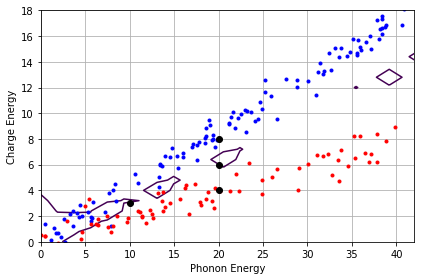

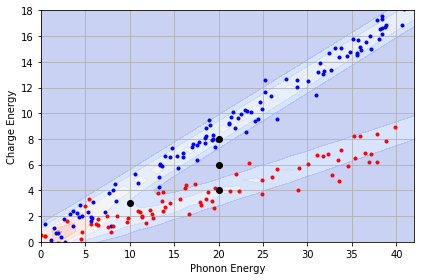

In [23]:
def dma1(p0,q0):
    L=2*np.log(FvarFE(p0,q0)/FvarFN(p0,q0))
    C=sp.erf(np.sqrt(np.abs(L)/2))
    if L>0:
        return "Electron", C
    elif L<0:
        return "Nuclear", C
    else:
        return "No Decision", C

def dma2(p0,q0):
    P_N = weight0*FvarFN(p0,q0)/FvarFNE(p0,q0)
    P_e = 1-P_N
    if P_N>.5:
        return "Nuclear",max(P_N,P_e)
    elif P_N<.5:
        return "Electron",max(P_N,P_e)
    else:
        return "No Decision",max(P_N,P_e)


Test_Points_Ep = [20,20,20,10] 
Test_Points_Eq = [4,6,8,3]

conf_level=[0.9]

Conf0 = np.vectorize(dma1)

zzC = Conf0(pp1,qq1)[1]

for indexi in range(len(Test_Points_Ep)):
    print(dma1(Test_Points_Ep[indexi],Test_Points_Eq[indexi]))
    print(dma2(Test_Points_Ep[indexi],Test_Points_Eq[indexi]))
    print()

plt.contour(p1,q1,zzC,levels=conf_level)
#plt.contour(zzEsum, tE_contours, extent=[0,18*(1+V/eps),0,18])
#plt.contour(zzNsum, tN_contours, extent=[0,18*(1+V/eps),0,18])
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.plot(Test_Points_Ep,Test_Points_Eq,'ko',label = "Test Points")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.grid()
plt.show()


xData=np.concatenate((xE,xN))
yData=np.concatenate((yE,yN))

plt.contourf(p1,q1,zzNE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.plot(Test_Points_Ep,Test_Points_Eq,'ko',label = "Test Points")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.grid()
plt.show()


# Relative Frequency Estimation

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in sqrt


0.0
0.0
1.2925084054989775e-210
1.1641063608717203e-130
3.983573265770578e-86
2.8733400299421095e-56
1.493786243254338e-34
4.635498161112015e-18
3.1030734873341866e-05
380637.3318491145
33868567920083.176
5.564427500016274e+19
3.2682432299470817e+24
1.1108825494000446e+28
3.129836488980678e+30
9.598449407698728e+31
3.948104443569691e+32
2.5579908476726742e+32
2.9536132299244452e+31
6.675218980123919e+29
3.1650096052026753e+27
3.306111311187204e+24
7.848817631424252e+20
4.299690752204611e+16
543794554092.28986
1566462.808632966
1.0
1.3572216869094778e-07
3.701759408491634e-15
1.8873396910182166e-23
1.6437807402532455e-32
2.1903547196778897e-42
3.907202552024381e-53
7.942585987491447e-65
1.5153945020702072e-77
2.1466468998520389e-91
1.698627676712726e-106
5.30197747121012e-123
4.248285034441397e-141
5.107974205507578e-161
4.6636194563083604e-183
1.3410889226155623e-207
3.7987799389356025e-235
2.1883647425519124e-266
2.79835262950994e-302
0.0
0.0
0.0
0.0
0.0
0.0


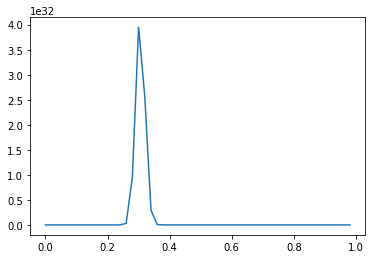

In [11]:
def weightdist(x):
    prod = 1
    for i in np.random.choice(range(len(xData)),1000,replace=False):
        prodi = 2*(x*FvarFN(xData[i],yData[i])+(1-x)*FvarFE(xData[i],yData[i]))/(FvarFN(xData[i],yData[i])+FvarFE(xData[i],yData[i]))
        prod=prod*prodi
    print(prod)
    return prod
        
x1 = np.arange(0, 1, .02)
weightdist = np.vectorize(weightdist)

weightdistarr = weightdist(x1)

plt.plot(x1,weightdistarr)
plt.show()

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in sqrt


2.4982795459507207e+29
2.4982795459507274e+29
4.3358951108188656e+29
7.353171122103919e+29
1.2188246974730764e+30
1.9750951362716901e+30
3.1298364889806746e+30
4.8511644595206685e+30
7.356347137166898e+30
1.0916132931144056e+31
1.5854836057668446e+31
2.254418308079917e+31
3.1389045223168186e+31
4.280369513718216e+31
5.7178187144642005e+31
7.4835841838122855e+31
9.598449407698732e+31
1.2066590818030445e+32
1.48709263139391e+32
1.796955172770003e+32
2.129394646490754e+32
2.474951962524682e+32
2.821884594991563e+32
3.156762686542383e+32
3.4653046663336664e+32
3.733383381626486e+32
3.9481044435699016e+32
4.098841413023173e+32
4.178111283828356e+32
4.1821894511371165e+32
4.1113939737732774e+32
3.970009764472198e+32
3.7658678897065214e+32
3.5096364133165156e+32
3.213910955294879e+32
2.8922110579769707e+32
2.5579908476728046e+32
2.223760343965999e+32
1.9003903687100877e+32
1.596644058193342e+32
1.3189466448142582e+32
1.0713770965391507e+32
8.558437989979025e+31
6.7239354370407425e+31
5.195988

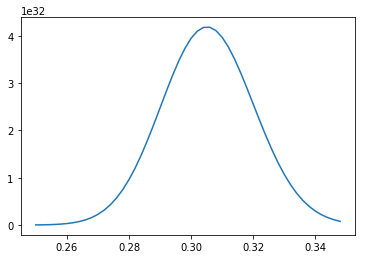

In [12]:
x1 = np.arange(.25, .35, .002)
weightdistarr2 = weightdist(x1)

plt.plot(x1,weightdistarr2)
plt.show()

In [16]:
x1[np.argmax(weightdistarr2)]

0.30600000000000005

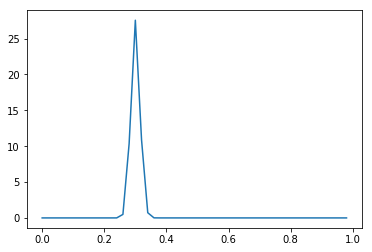

In [17]:
def weightdist2(x):
    alpha = len(xN)+1
    beta = len(xE)+1
    return (x**(alpha-1))*((1-x)**(beta-1))/sp.beta(alpha,beta)

x1 = np.arange(0, 1, .02)
weightdist2 = np.vectorize(weightdist2)

weightdistarr3 = weightdist2(x1)

plt.plot(x1,weightdistarr3)
plt.show()

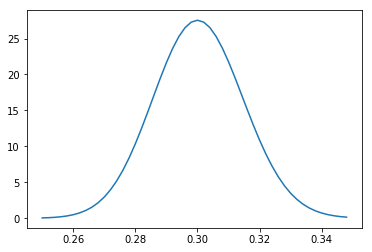

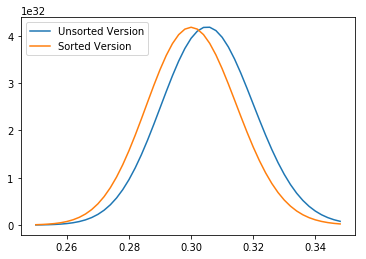

In [21]:
x1 = np.arange(.25, .35, .002)
weightdistarr4 = weightdist2(x1)

plt.plot(x1,weightdistarr4)
plt.show()

plt.plot(x1,weightdistarr2,label = "Unsorted Version")
plt.plot(x1,weightdistarr4*(max(weightdistarr2)/max(weightdistarr4)),label = "Sorted Version")
plt.legend()
plt.show()

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in sqrt


1000


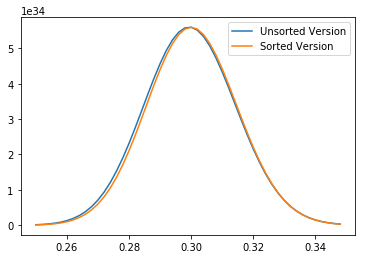

In [15]:
def weightdist(x,EpData,EqData):
    q=FvarFNv(xData,yData)/(FvarFNv(xData,yData)+FvarFEv(xData,yData))
    print(len(q))
    prod = 1
    for i in q:
        prod=prod*(1+(2*i-1)*(2*x-1))
    return prod

def weightdist2(x):
    alpha = len(xN)+1
    beta = len(xE)+1
    return (x**(alpha-1))*((1-x)**(beta-1))/sp.beta(alpha,beta)

x1 = np.arange(.25, .35, .002)

weightdistarr5 = weightdist(x1,xData,yData)
weightdistarr6 = weightdist2(x1)

plt.plot(x1,weightdistarr5,label = "Unsorted Version")
plt.plot(x1,weightdistarr6*(max(weightdistarr5)/max(weightdistarr6)),label = "Sorted Version")
plt.legend()
plt.show()

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in sqrt


[[3.35830958e-26]
 [2.52867080e-49]
 [5.29276853e-50]
 [8.66087444e-01]
 [2.72461551e-05]
 [1.61786997e-05]
 [3.72318229e-58]
 [1.26375228e-68]
 [4.14546561e-33]
 [2.29228510e-58]
 [8.00229847e-71]
 [5.68284595e-70]
 [2.81445615e-63]
 [8.43448886e-01]
 [1.89136738e-18]
 [6.65325310e-50]
 [5.26565712e-04]
 [1.00234143e-62]
 [1.49675918e-53]
 [4.28285177e-68]
 [3.62152806e-37]
 [1.97057105e-74]
 [2.28580634e-42]
 [5.94898799e-56]
 [3.82663490e-68]
 [2.67251213e-45]
 [1.36818325e-59]
 [2.70224125e-69]
 [4.31228915e-74]
 [8.22956284e-70]
 [2.09346321e-56]
 [3.75240484e-55]
 [1.78720025e-69]
 [2.96580182e-45]
 [9.57252144e-48]
 [3.56463735e-66]
 [3.57293288e-51]
 [3.48112195e-61]
 [5.44350038e-69]
 [7.37723329e-65]
 [3.51446304e-66]
 [1.73416088e-20]
 [3.80074487e-03]
 [3.50385385e-76]
 [2.00696494e-62]
 [3.74394379e-31]
 [7.25569389e-21]
 [3.56605697e-71]
 [3.31195730e-02]
 [5.46045639e-05]
 [1.38511439e-67]
 [4.60533775e-56]
 [1.07119406e-68]
 [1.02950038e-52]
 [2.96485973e-60]
 [1.433117

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


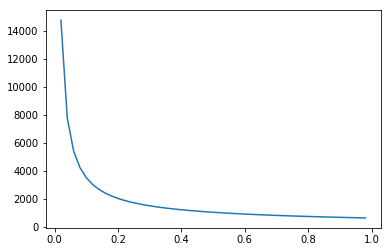

In [36]:
def logderweightdist(x,EpData,EqData):
    q=FvarFNv(EpData,EqData)/(FvarFNv(EpData,EqData)+FvarFEv(EpData,EqData))
    try:
        s=[]
        for j in x:
            s0=0
            for i in q:
                s0=s0+1/(1+j-i)
            s.append(s0)
    except:
        s=0
        for i in q:
            s=s+1/(1+x-i)
    return s

x1 = np.arange(0, 1, .02)

plt.plot(x1,logderweightdist(x1,xData,yData))
plt.show()
    